In [12]:
import requests
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from scipy import ndimage, stats, signal
from skimage.util import random_noise

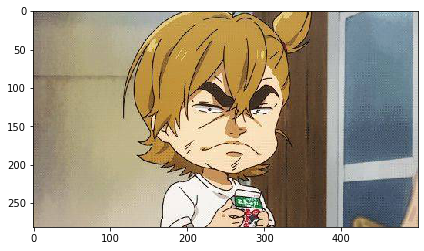

In [13]:
url = 'https://cdn.myanimelist.net/s/common/uploaded_files/1482965945-3d9561fa5a014da11e0dd3b2f148b1b0.jpeg'

# Faz o download da imagem
response = requests.get(url)

# Salva a imagem em um arquivo
with open("image.jpg", "wb") as f:
    f.write(response.content)

# Carrega a imagem do arquivo
imagem = io.imread("image.jpg")

# Exibe a imagem
io.imshow(imagem)
io.show()

# Filtragem espacial linear

## Implementação

### Gerador de filtros

A função gerar_filtro() gera filtros comuns com base em um tipo de filtro escolhido e tamanho do filtro. O tipo de filtro deve ser um dos seguintes: "identidade", "blur", "sharpen" e "edge_detect". O tamanho do filtro deve ser ímpar. A função retorna uma matriz do filtro gerado. O filtro também pode ser retangular, onde o número de linhas e colunas podem ser diferentes.

O filtro de "identidade" é uma matriz diagonal com valor 1 e outros elementos com valor 0, ele não altera a imagem.
O filtro de "blur" é uma matriz com valores 1 e dividido pelo tamanho do filtro ao quadrado, ele suaviza a imagem.
O filtro de "sharpen" é uma matriz com valor -1 em sua maioria e 2 no centro, ele aumenta os detalhes da imagem.
O filtro de "edge_detect" é uma matriz com valor -1 em sua maioria e 4 no centro, ele destaca as bordas da imagem.

In [14]:
def gerar_filtro(tipo, linhas, colunas):
    if linhas % 2 == 0 or colunas % 2 == 0:
        raise ValueError("Tamanho do filtro deve ser ímpar.")
    if tipo == "identidade":
        return np.eye(linhas, colunas, dtype=np.float32)
    elif tipo == "blur":
        return np.ones((linhas, colunas), dtype=np.float32) / (linhas * colunas)
    elif tipo == "sharpen":
        filtro = np.zeros((linhas, colunas), dtype=np.float32)
        filtro[linhas//2, colunas//2] = 2
        filtro = filtro - np.ones((linhas, colunas), dtype=np.float32) / (linhas * colunas)
        return filtro
    elif tipo == "edge_detect":
        filtro = np.zeros((linhas, colunas), dtype=np.float32)
        filtro[linhas//2, colunas//2] = 4
        filtro[linhas//2-1:linhas//2+1, colunas//2-1:colunas//2+1] = -1
        return filtro
    elif tipo == "laplacian":
        filtro = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
        return filtro
    else:
        raise ValueError("Tipo de filtro inválido. Deve ser 'identidade', 'blur', 'sharpen', 'edge_detect' ou 'laplacian'.")


### Aplicar padding em uma imagem
Nessa função, image é a imagem a ser processada, padding é a quantidade de pixels a serem adicionados na borda (pode ser uma tupla de inteiros para adicionar pixels diferentes nas bordas superior/inferior e esquerda/direita) e mode é o tipo de padding a ser aplicado. A função retorna a imagem com o padding aplicado.

In [15]:
def apply_padding(image, row_padding, col_padding, mode='ignore'):
    if mode == 'ignore':
        return image
    elif mode == 'espelho':
        return np.pad(image, ((row_padding[0], row_padding[1]), (col_padding[0], col_padding[1])), mode='reflect')
    elif mode == 'zero':
        return np.pad(image, ((row_padding[0], row_padding[1]), (col_padding[0], col_padding[1])), mode='constant', constant_values=0)
    elif mode == 'replicar':
        return np.pad(image, ((row_padding[0], row_padding[1]), (col_padding[0], col_padding[1])), mode='edge')
    else:
        raise ValueError("Invalid padding mode")

### Convolução

A função "convolução" é utilizada para aplicar um filtro de convolução em uma imagem. Ela recebe como parâmetros a imagem a ser processada, o filtro a ser aplicado e o tratamento a ser feito na borda da imagem. O filtro é uma matriz MxN, onde M e N são ímpares, maiores ou iguais a 3 e menores que o tamanho da imagem (em cada dimensão). O parâmetro borda pode ter 4 valores possíveis: "ignore", "espelho", "zero" ou "replicar".

A função começa verificando se o tamanho do filtro é válido, ou seja, se é ímpar e menor que a imagem. Caso contrário, é gerado um erro. Em seguida, é criada uma cópia da imagem para não alterar a original.

Em seguida, é definido o tratamento da borda, onde é adicionado colunas e linhas na borda da imagem de acordo com o parâmetro escolhido.

Por fim, é aplicado o filtro na imagem, percorrendo-a linha por linha e coluna por coluna. Para cada posição, é obtida uma submatriz da imagem que será processada pelo filtro e é aplicado o filtro na submatriz. O resultado é atribuído à posição correspondente na imagem processada.

A função retorna a imagem processada com o filtro aplicado.

In [16]:
def convolution(image, kernel, border_treatment):
    kernel = np.flip(np.flip(kernel, 0), 1)
    if len(image.shape) == 3:
        # imagem colorida
        result = np.zeros_like(image)
        for i in range(3):
            result[:,:,i] = convolution(image[:,:,i], kernel, border_treatment)
        return result
        
    else:
        # imagem em tons de cinza
        row = (int((kernel.shape[0]-1)/2),int((kernel.shape[0]-1)/2))
        col = (int((kernel.shape[0]-1)/2), int((kernel.shape[0]-1)/2))

        padded_image = apply_padding(image, row, col, border_treatment)
        result = np.zeros_like(image)
        for row in range(image.shape[0]):
            for col in range(image.shape[1]):
                result[row, col] = np.sum(np.multiply(padded_image[row:row+kernel.shape[0], col:col+kernel.shape[1]], kernel))
        return result



## Teste

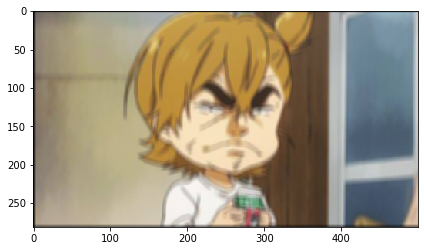

In [17]:

filtro = gerar_filtro('blur', 9, 5)

imgGray = rgb2gray(imagem)
imgCopy = imagem.copy()

imgResult = convolution(imgCopy, filtro, 'zero')

io.imshow(imgResult)
io.show()


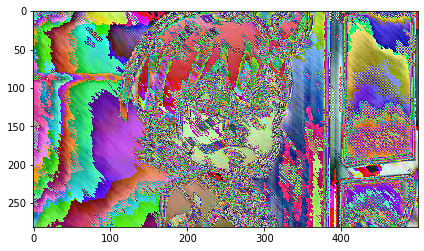

In [18]:
filtro = gerar_filtro('identidade', 9, 9)

# imgGray = rgb2gray(imagem)
imgCopy = imagem.copy()

imgResult = convolution(imgCopy, filtro, 'replicar')

io.imshow(imgResult)
io.show()

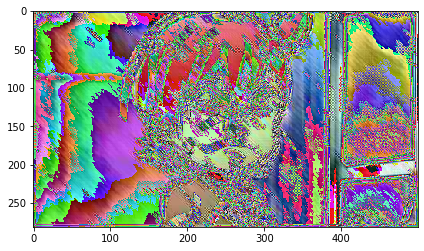

In [19]:
filtro = gerar_filtro('identidade',  9, 9)

# imgGray = rgb2gray(imagem)
imgCopy = imagem.copy()

imgResult = convolution(imgCopy, filtro, 'zero')

io.imshow(imgResult)
io.show()

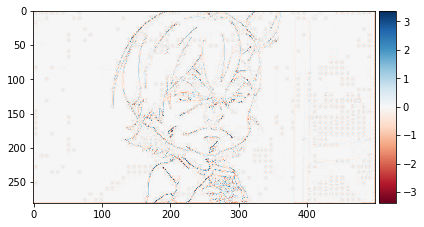

In [20]:
filtro = gerar_filtro('laplacian',  9, 9)

imgGray = rgb2gray(imagem)
# imgCopy = imagem.copy()

imgResult = convolution(imgGray, filtro, 'zero')

io.imshow(imgResult)
io.show()

O filtro laplaciano aplicado na imagem deixou evidente as bordas do objeto.

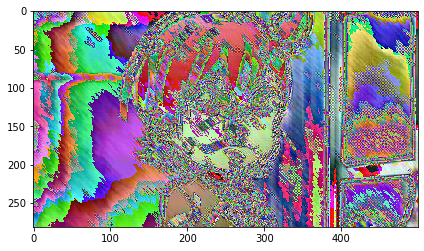

In [21]:
filtro = gerar_filtro('identidade',  9, 9)

# imgGray = rgb2gray(imagem)
imgCopy = imagem.copy()

imgResult = convolution(imgCopy, filtro, 'espelho')

io.imshow(imgResult)
io.show()

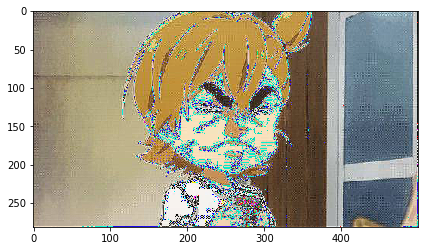

In [22]:
filtro = gerar_filtro('sharpen', 3, 3)

imgGray = rgb2gray(imagem)
imgCopy = imagem.copy()

imgResult = convolution(imgCopy, filtro, 'zero')

io.imshow(imgResult)
io.show()

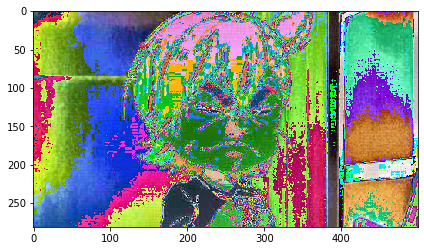

In [23]:
filtro = gerar_filtro('edge_detect', 9, 9)

imgGray = rgb2gray(imagem)
imgCopy = imagem.copy()

imgResult = convolution(imgCopy, filtro, 'zero')

io.imshow(imgResult)
io.show()

# Filtragem espacial não linear

In [24]:
def apply_nonlinear_filter(image, filter_type, kernel_size):
    if filter_type not in ["median", "mode", "max", "min"]:
        raise ValueError("Invalid filter type. Choose from 'median', 'mode', 'max', 'min'.")

    kernel = np.ones((kernel_size, kernel_size))
    
    if len(image.shape) == 3: # image is RGB
        filtered_image = np.zeros_like(image)
        for i in range(3): # apply filter to each channel
            if filter_type == "median":
                filtered_image[:,:,i] = ndimage.median_filter(image[:,:,i], size=kernel_size)
            elif filter_type == "mode":
                filtered_image[:,:,i] = ndimage.correlate(image[:,:,i], kernel)
            elif filter_type == "max":
                filtered_image[:,:,i] = ndimage.maximum_filter(image[:,:,i], size=kernel_size)
            elif filter_type == "min":
                filtered_image[:,:,i] = ndimage.minimum_filter(image[:,:,i], size=kernel_size)
    else: # image is grayscale
        if filter_type == "median":
            filtered_image = ndimage.median_filter(image, size=kernel_size)
        elif filter_type == "mode":
            filtered_image = ndimage.correlate(image, kernel)
        elif filter_type == "max":
            filtered_image = ndimage.maximum_filter(image, size=kernel_size)
        elif filter_type == "min":
            filtered_image = ndimage.minimum_filter(image, size=kernel_size)

    return filtered_image


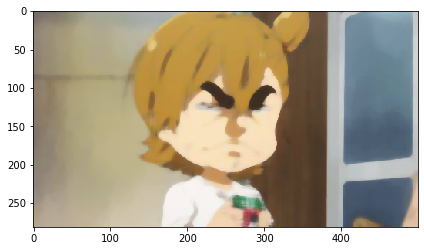

In [25]:
imgGray = rgb2gray(imagem)
imgCopy = imagem.copy()

imgResult = apply_nonlinear_filter(imgCopy, 'median', 9)

io.imshow(imgResult)
io.show()

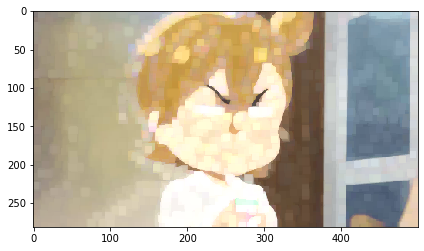

In [26]:
imgGray = rgb2gray(imagem)
imgCopy = imagem.copy()

imgResult = apply_nonlinear_filter(imgCopy, 'max', 9)

io.imshow(imgResult)
io.show()

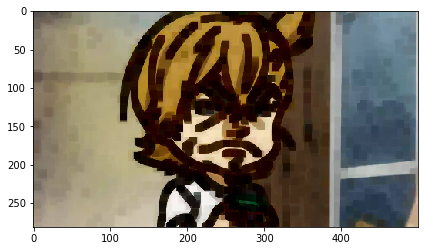

In [27]:
imgGray = rgb2gray(imagem)
imgCopy = imagem.copy()

imgResult = apply_nonlinear_filter(imgCopy, 'min', 9)

io.imshow(imgResult)
io.show()

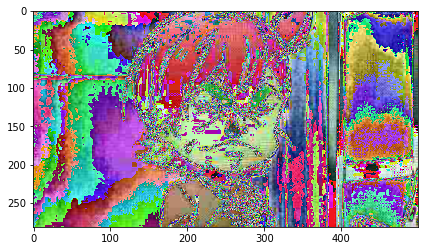

In [28]:
imgGray = rgb2gray(imagem)
imgCopy = imagem.copy()

imgResult = apply_nonlinear_filter(imgCopy, 'mode', 3)

io.imshow(imgResult)
io.show()

# Máscara de Nitidez

Para implementar uma máscara de nitidez, primeiramente deve-se criar uma matriz do kernel de máscara com valores -1, -1, -1, -1, 9 e -1, -1, -1, -1. Em seguida, aplique essa máscara na imagem utilizando o algoritmo de convolução mencionado na questão 1. Isso irá realçar as bordas e os detalhes na imagem, dando a impressão de nitidez.

Para implementar a filtragem high-boost, primeiramente deve-se escolher um valor para k (0 < k < 2). Em seguida, crie uma matriz do kernel de máscara com valores -1, -1, -1, -1, 1+k e -1, -1, -1, -1. Em seguida, aplique essa máscara na imagem utilizando o algoritmo de convolução mencionado na questão 1. Isso irá realçar as bordas e os detalhes na imagem, mas em maior intensidade do que a máscara de nitidez, dado pelo valor de k.

Os resultados das duas implementações serão similares, mas a filtragem high-boost terá uma intensidade maior na nitidez.

Valores de k sugeridos:

0,5
0,8
1,0
1,2
1,5

In [29]:
def sharpnessImage(img, filtro):
    return convolution(img, filtro, 'zero')

def highboostMask(img, filtro):
    return convolution(imgGray, filtro, 'zero')


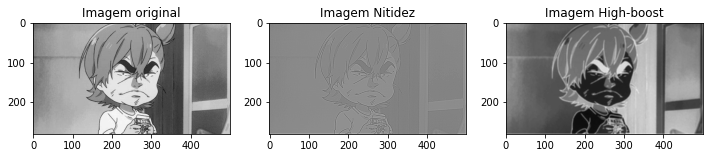

In [30]:
# Converta para tons de cinza
imgGray = rgb2gray(imagem)

# Crie a máscara de nitidez
filtro = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

# Aplique a máscara de nitidez na imagem usando o algoritmo de convolução
sharpness_image = sharpnessImage(imgGray, filtro)

# Crie a máscara high-boost com k = 0,5
k = 0.5
highboost_mask = np.array([[-1, -1, -1], [-1, 1+k, -1], [-1, -1, -1]])

# Aplique a máscara high-boost na imagem usando o algoritmo de convolução
highboost_image = highboostMask(imgGray, highboost_mask)

plt.figure(figsize=(12,5))
plt.subplot(131)
plt.imshow(imgGray, cmap='gray')
plt.title("Imagem original")
plt.subplot(132)
plt.imshow(sharpness_image, cmap='gray')
plt.title("Imagem Nitidez")
plt.subplot(133)
plt.imshow(highboost_image, cmap='gray')
plt.title("Imagem High-boost")
plt.show()

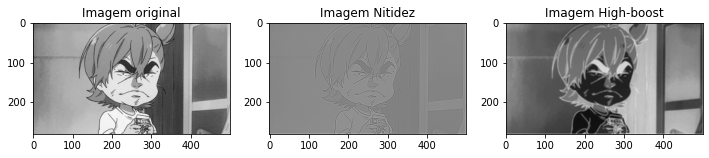

In [31]:
# Converta para tons de cinza
imgGray = rgb2gray(imagem)

# Crie a máscara de nitidez
filtro = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

# Aplique a máscara de nitidez na imagem usando o algoritmo de convolução
sharpness_image = sharpnessImage(imgGray, filtro)

# Crie a máscara high-boost com k = 0,8
k = 0.8
highboost_mask = np.array([[-1, -1, -1], [-1, 1+k, -1], [-1, -1, -1]])

# Aplique a máscara high-boost na imagem usando o algoritmo de convolução
highboost_image = highboostMask(imgGray, highboost_mask)

plt.figure(figsize=(12,5))
plt.subplot(131)
plt.imshow(imgGray, cmap='gray')
plt.title("Imagem original")
plt.subplot(132)
plt.imshow(sharpness_image, cmap='gray')
plt.title("Imagem Nitidez")
plt.subplot(133)
plt.imshow(highboost_image, cmap='gray')
plt.title("Imagem High-boost")
plt.show()

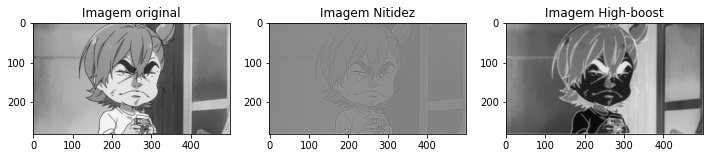

In [32]:
# Converta para tons de cinza
imgGray = rgb2gray(imagem)

# Crie a máscara de nitidez
filtro = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

# Aplique a máscara de nitidez na imagem usando o algoritmo de convolução
sharpness_image = sharpnessImage(imgGray, filtro)

# Crie a máscara high-boost com k = 1
k = 0.1
highboost_mask = np.array([[-1, -1, -1], [-1, 1+k, -1], [-1, -1, -1]])

# Aplique a máscara high-boost na imagem usando o algoritmo de convolução
highboost_image = highboostMask(imgGray, highboost_mask)

plt.figure(figsize=(12,5))
plt.subplot(131)
plt.imshow(imgGray, cmap='gray')
plt.title("Imagem original")
plt.subplot(132)
plt.imshow(sharpness_image, cmap='gray')
plt.title("Imagem Nitidez")
plt.subplot(133)
plt.imshow(highboost_image, cmap='gray')
plt.title("Imagem High-boost")
plt.show()

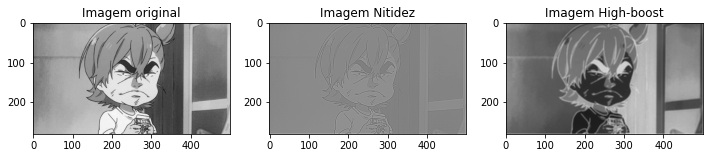

In [33]:
# Converta para tons de cinza
imgGray = rgb2gray(imagem)

# Crie a máscara de nitidez
filtro = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

# Aplique a máscara de nitidez na imagem usando o algoritmo de convolução
sharpness_image = sharpnessImage(imgGray, filtro)

# Crie a máscara high-boost com k = 1.2
k = 1.2
highboost_mask = np.array([[-1, -1, -1], [-1, 1+k, -1], [-1, -1, -1]])

# Aplique a máscara high-boost na imagem usando o algoritmo de convolução
highboost_image = highboostMask(imgGray, highboost_mask)

plt.figure(figsize=(12,5))
plt.subplot(131)
plt.imshow(imgGray, cmap='gray')
plt.title("Imagem original")
plt.subplot(132)
plt.imshow(sharpness_image, cmap='gray')
plt.title("Imagem Nitidez")
plt.subplot(133)
plt.imshow(highboost_image, cmap='gray')
plt.title("Imagem High-boost")
plt.show()

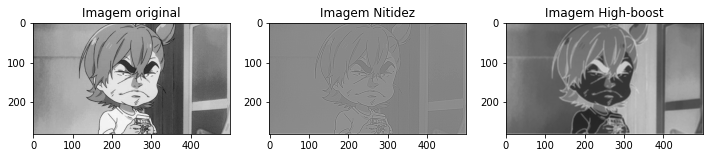

In [34]:
# Converta para tons de cinza
imgGray = rgb2gray(imagem)

# Crie a máscara de nitidez
filtro = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

# Aplique a máscara de nitidez na imagem usando o algoritmo de convolução
sharpness_image = sharpnessImage(imgGray, filtro)

# Crie a máscara high-boost com k = 1.5
k = 1.5
highboost_mask = np.array([[-1, -1, -1], [-1, 1+k, -1], [-1, -1, -1]])

# Aplique a máscara high-boost na imagem usando o algoritmo de convolução
highboost_image = highboostMask(imgGray, highboost_mask)

plt.figure(figsize=(12,5))
plt.subplot(131)
plt.imshow(imgGray, cmap='gray')
plt.title("Imagem original")
plt.subplot(132)
plt.imshow(sharpness_image, cmap='gray')
plt.title("Imagem Nitidez")
plt.subplot(133)
plt.imshow(highboost_image, cmap='gray')
plt.title("Imagem High-boost")
plt.show()

In [35]:

filters = ['gaussian', 'localvar', 'poisson', 'salt', 'pepper', 's&p', 'speckle']

filtro = np.array(
   [
        [1/9, 1/9, 1/9],
        [1/9, 1/9, 1/9],
        [1/9, 1/9, 1/9],
    ]
)

for i in filters:
    image_noise = random_noise(imagem, mode=i)
    plt.imshow(image_noise)
    plt.show()

    imgCopy = imagem.copy()
    image_denoise = convolution(imgCopy, filtro, 'zero')
    plt.imshow(image_denoise)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.